In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils
import torch
import numpy as np
import nibabel as nib
from random import randint
from PIL import Image
import torch.optim as optim
import time
import QuickNAT as QN
import torch.nn as nn
from livelossplot import PlotLosses
import matplotlib.pyplot as plt

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print(device)

cuda


In [3]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, T1a_dir, parc1a_dir, transform=None):
        """
        Args:
            T1a_dir (string): Directory with T1w image in axial plane
            transform (callable): Optional transform to be applied on a sample
            parc1a_dir (string): Directory with parcellation scale 5 in axial plane
        """
        self._T1a_dir = T1a_dir
        self.transform = transform
        self._parc1a_dir = parc1a_dir
#         self.mapping = {
#             167: 86,
#             168: 91,
#             169: 166
#         }
        
#     def mask_to_class(self, mask):
#         for k in self.mapping:
#             mask[mask==k] = self.mapping[k]
#         return mask
    
    def __len__(self):
        T1a_list = os.listdir(self._T1a_dir)
        return len(T1a_list)
    
    
    def __getitem__(self, idx):
        T1a_list = os.listdir(self._T1a_dir)
        parc1a_list = os.listdir(self._parc1a_dir)
        
        T1a_str = T1a_list[idx]
        
        T1a_arr = io.imread(os.path.join(self._T1a_dir, T1a_str))
        T1a_tensor = torch.from_numpy(T1a_arr)
        
        compose_T1 = transforms.Compose([transforms.ToPILImage(), 
                                         transforms.Resize((128,128),interpolation=Image.NEAREST),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        T1a_tensor = torch.unsqueeze(T1a_tensor, dim = 0)
        T1a_tensor = compose_T1(T1a_tensor)
              
        parc1a_str = parc1a_list[idx]
    
        parc1a_arr = io.imread(os.path.join(self._parc1a_dir, parc1a_str))
        parc1a_tensor = torch.from_numpy(parc1a_arr)
        
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((128,128),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        parc1a_tensor = torch.unsqueeze(parc1a_tensor, dim = 0)
        parc1a_tensor = compose(parc1a_tensor)
        parc1a_tensor = parc1a_tensor.squeeze()
        
        parc1a_tensor = torch.round(parc1a_tensor / 0.0039).byte()
#         parc1a_tensor = self.mask_to_class(parc1a_tensor)
      
        sample = {'T1a':T1a_tensor, 'parc1a':parc1a_tensor}
        
        if self.transform:
            T1a = self.transform(T1a_tensor)
            sample = {'T1a':T1a, 'parc1a':parc1a}
            
        return sample

In [4]:
sub_idx = 0
slice_idx = 1
T1a_dir = '/home/xiaoyu/MRIdata_group/T1w/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
parc1a_dir = '/home/xiaoyu/MRIdata_group/parc_1/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
total_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)
print(len(total_data))

10


In [5]:
for sub_idx in range(1,330):
    T1a_dir = '/home/xiaoyu/MRIdata_group/T1w/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
    parc1a_dir = '/home/xiaoyu/MRIdata_group/parc_1/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
    train_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)
    total_data = total_data + train_data
print(len(total_data))
# total training images pairs is 3300.

3300


In [6]:
colors = torch.tensor([])
for i in range(len(total_data)):
    sample = total_data[i]
    mask = sample['parc1a']
    unique_color = torch.unique(mask).float()
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)
print(sorted_color.size())

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  92.,  93.,  94.,  95.,  96.,
         97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
        109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
        133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
        145., 146., 147., 148., 149., 15

In [7]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  27  28  30  37  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  79  80  82  89  99 100
 103 104 105 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 142 143 144 145 147]


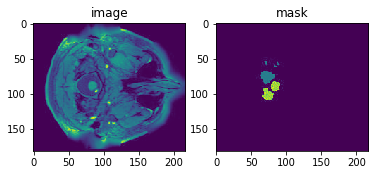

In [8]:
# test the function

T1a_dir = '/home/xiaoyu/MRIdata_group/T1w/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
parc1a_dir = '/home/xiaoyu/MRIdata_group/parc_1/axial/sub{}/slice{}'.format(sub_idx,slice_idx)

T1a_list = os.listdir(T1a_dir)
parc1a_list = os.listdir(parc1a_dir)

T1a_str = T1a_list[1]
parc1a_str = parc1a_list[1]

T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
parc1a_arr = io.imread(os.path.join(parc1a_dir, parc1a_str))
unique_color = np.unique(parc1a_arr)
print(unique_color)

show_mask(T1a_arr, parc1a_arr)